# Harnessing the Power of AWS SageMaker & NannyML: From Training & Deployment to Monitoring. 

# PART 1: Training and Deploying an XGboost Model on AWS SageMaker

In [1]:
# !pip install xgboost

## Setting up

In [2]:
# Import necessary libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import sagemaker, boto3, tarfile, sklearn, xgboost
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer

In [3]:
# Set up the SageMaker session, region, and execution role
sess = sagemaker.Session()
region = sess.boto_region_name
role = sagemaker.get_execution_role()

In [4]:
# Define S3 bucket details
bucket_name = 'demo-nannyml'
prefix = 'california-housing'

## Fetching the data

In [5]:
# Load the data 
data_path = 'data/california-housing-dataset/{}.csv'
train = pd.read_csv(data_path.format('train'))
test = pd.read_csv(data_path.format('test'))
prod = pd.read_csv(data_path.format('prod'))

# Observe the data
train.sample(5)

,Target,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
5754,1,47.0,7.031348,1.062696,911.0,2.855799,34.18,-118.28
3464,0,32.0,5.785203,1.136038,2291.0,5.467780,34.30,-118.46
4187,1,37.0,4.314149,1.021583,1088.0,2.609113,34.13,-118.23
4483,0,47.0,3.912458,1.107744,3020.0,5.084175,34.06,-118.19
5669,1,40.0,4.391156,1.030612,1304.0,2.217687,33.73,-118.30


In [6]:
# # Create a new S3 bucket for storing data
s3 = boto3.client('s3')
# s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})

In [7]:
# Define paths for the train, test, and prod data in S3
s3_train_path = f's3://{bucket_name}/{prefix}/train/'
s3_train_csv_path = s3_train_path + 'train.csv'
s3_test_csv_path = f's3://{bucket_name}/{prefix}/test.csv'
s3_prod_csv_path = f's3://{bucket_name}/{prefix}/prod.csv'

# Upload the data to the S3 bucket
train.to_csv(s3_train_csv_path, index=False)
prod.to_csv(s3_prod_csv_path, index=False)

## Training an XGBoost model on AWS Sagemaker

In [8]:
# Retrieve the image URI for XGBoost in the current region
image_uri = sagemaker.image_uris.retrieve('xgboost', region, '1.7-1')


In [9]:
# Define the XGBoost estimator with specified parameters
xgb = sagemaker.estimator.Estimator(
    image_uri,
    output_path=f's3://{bucket_name}/{prefix}/training_result',
    instance_count=1,
    instance_type='ml.m4.xlarge',
    sagemaker_session=sess,
    role=role,
)

# Set hyperparameters for the XGBoost model
xgb.set_hyperparameters(
    objective='binary:logistic',
    num_round=100,
    max_depth=3,
)

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.


In [10]:
# Specify the training data location
training_input = TrainingInput(
    s3_data=s3_train_path, content_type='csv'
)

# Train the model using the training data
xgb.fit({'train': training_input})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-09-22-09-16-58-827


2023-09-22 09:16:58 Starting - Starting the training job...
2023-09-22 09:17:25 Starting - Preparing the instances for training.........
2023-09-22 09:18:31 Downloading - Downloading input data...
2023-09-22 09:19:06 Training - Downloading the training image...
2023-09-22 09:19:42 Training - Training image download completed. Training in progress..[2023-09-22 09:19:57.301 ip-10-0-218-165.eu-central-1.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-09-22 09:19:57.331 ip-10-0-218-165.eu-central-1.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-09-22:09:19:57:INFO] Imported framework sagemaker_xgboost_container.training
[2023-09-22:09:19:57:INFO] Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
[2023-09-22:09:19:57:INFO] No GPUs detected (normal if no gpus installed)
[2023-09-22:09:19:57:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-09-22:09:19:57:INFO] Deter

In [11]:
# Get the path of the trained model artifact in S3
s3_model_file_path = xgb.latest_training_job.describe()['ModelArtifacts']['S3ModelArtifacts']
print(s3_model_file_path)

s3://demo-nannyml/california-housing/training_result/sagemaker-xgboost-2023-09-22-09-16-58-827/output/model.tar.gz


# Analyzing the model

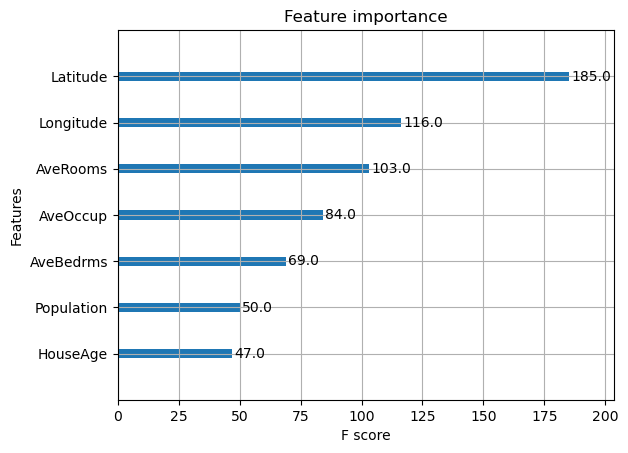

In [12]:
# Download the trained model artifact to the local environment
s3.download_file(bucket_name, s3_model_file_path.split(bucket_name + '/')[1], 'model.tar.gz')

# Extract the model artifact
with tarfile.open('model.tar.gz') as tar: tar.extractall()
    
# Load the model and set its feature names
xgb_model = xgboost.Booster()
xgb_model.load_model('xgboost-model')
xgb_model.feature_names = list(train.columns[1:])

# Plot the feature importance of the trained model
fig, ax = plt.subplots()
xgboost.plot_importance(xgb_model, ax=ax)
plt.show()

# Evaluating the model

In [13]:
# Get predictions for the test dataset
test_scores = xgb_model.predict(xgboost.DMatrix(test.iloc[:,1:]))

# Measure ROC AUC
print('Test ROC AUC Score = ', round(sklearn.metrics.roc_auc_score(y_true=test['Target'], y_score=test_scores),2))

Test ROC AUC Score =  0.78


In [14]:
# Assign prediction scores and predictions to the test and write to S3
test['prediction_score'] = test_scores
test['prediction'] = test_scores > 0.5
s3_reference_csv_path = f's3://{bucket_name}/{prefix}/reference.csv'
test.to_csv(s3_reference_csv_path, index=False)

# Deploying the model

In [17]:
# Deploy the trained model as an endpoint
xgb_predictor = xgb.deploy(
    endpoint_name=prefix + '-endpoint',
    initial_instance_count=1, 
    instance_type="ml.m4.xlarge", 
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-09-22-09-26-42-315
INFO:sagemaker:Creating endpoint-config with name california-housing-endpoint
INFO:sagemaker:Creating endpoint with name california-housing-endpoint


------!

# Testing the end-point

In [18]:
# Make predictions using the deployed endpoint
end_point_output = xgb_predictor.predict(test.iloc[:5,1:-2], initial_args={'ContentType': 'text/csv'})

# Compare end-point predictions with test_scores
all(test_scores[:5] == [float(i) for i in end_point_output.decode().split()])

True

# Cleaning up

In [19]:
# Delete the deployed endpoint to prevent further charges
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: california-housing-endpoint
INFO:sagemaker:Deleting endpoint with name: california-housing-endpoint
